In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import cvxpy as cp

In [10]:
# Import MSCI Europe.xslx

df = pd.read_excel("MSCI_EUROPE.xlsx")

df.head()

,Name,Symbol,% Index Weight,Adj. Market Value,Adj. Shares,Price,1 Day %Change,Country,Sector Name
0,MSCI Europe,EU000U-MSX,100.000000,9.676385e+06,-,1803.145077,0.461555,NaN,NaN
1,Brenntag AG,BNR-DE,0.123562,1.195631e+04,154.5,77.387100,0.764807,Germany,Industrials
2,LANXESS AG,LXS-DE,0.064291,6.220998e+03,83.0755,74.883700,1.678890,Germany,Materials
3,Telefonica Deutschland Holding AG,O2D-DE,0.029262,2.831495e+03,1041.09,2.719730,-1.316500,Germany,Communication Services
4,EXOR N.V.,EXO-IT,0.082157,7.949806e+03,108.45,73.303900,1.369560,Italy,Financials


In [11]:
# Discard first row referring to MSCI Europe index

df = df.loc[1:]

In [14]:
df.describe()

,% Index Weight,Adj. Market Value,Price,1 Day %Change
count,434.000000,434.000000,434.000000,434.000000
mean,0.230415,22295.817750,365.795220,0.655385
std,0.331483,32075.567298,4640.770395,1.714351
min,0.023608,2284.393163,0.469451,-5.299480
25%,0.069040,6680.538579,17.418425,-0.452397
50%,0.115826,11207.800333,42.251400,0.734912
75%,0.251782,24363.415329,98.680825,1.647518
max,3.346350,323805.742652,96124.600000,7.861490


In [23]:
# pd.value_counts(df)

In [24]:
# Check for NAs

df.isna().sum(axis = 0)

Name                 0
Symbol               0
% Index Weight       0
Adj. Market Value    0
Adj. Shares          0
Price                0
1 Day %Change        0
Country              0
Sector Name          0
dtype: int64

In [25]:
# Check for feature's data types

df.dtypes

Name                  object
Symbol                object
% Index Weight       float64
Adj. Market Value    float64
Adj. Shares           object
Price                float64
1 Day %Change        float64
Country               object
Sector Name           object
dtype: object

In [26]:
# Filter per Sector & Country features

df_country_sector = df[['Country', 'Sector Name']]

In [27]:
df_country_sector.head()

,Country,Sector Name
1,Germany,Industrials
2,Germany,Materials
3,Germany,Communication Services
4,Italy,Financials
5,Germany,Industrials


In [28]:
# Generate Dummy categorical variables for both Country & Sector

df_dummies = pd.get_dummies(df_country_sector)
df_dummies.index = df['Symbol']

In [29]:
df_dummies.head()

,Country_Austria,Country_Belgium,Country_Denmark,Country_Finland,Country_France,Country_Germany,Country_Ireland,Country_Italy,Country_Netherlands,Country_Norway,...,Sector Name_Consumer Discretionary,Sector Name_Consumer Staples,Sector Name_Energy,Sector Name_Financials,Sector Name_Health Care,Sector Name_Industrials,Sector Name_Information Technology,Sector Name_Materials,Sector Name_Real Estate,Sector Name_Utilities
Symbol,,,,,,,,,,,,,,,,,,,,,
BNR-DE,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
LXS-DE,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
O2D-DE,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EXO-IT,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
MTX-DE,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [455]:
df_dummies.sum(axis = 1).head() # Two dummies per row -> Multicollinearity expected -> Handle with constraints

Symbol
BNR-DE    2
LXS-DE    2
O2D-DE    2
EXO-IT    2
MTX-DE    2
dtype: int64

## Set Constrained Regression

The model assumes that the stock return $R_{it}$ can be decomposed into factors associated with its **industry** affiliation, indexd by $j$, and **country** affiliation, indexed by $k$,

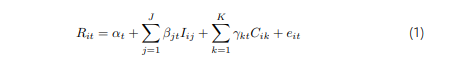 *(1)*

Here, $I_{ij}$ and $C_{ik}$ are dummy variables equal to **1** if stock $i$ belongs to industry $j$ and country $k$, respectively. $\beta_{jt}$ and $\gamma_{kt}$ are the respective industry- and country-specific effects: shocks that impact all firms within a given industry or within a given country. In addition to country and industry effects, $\alpha_{t}$ represents an effect relevant to all securities, which can be interpreted as a global effet, and $e_{it}$ represents the effects specific to firm $i$. In order to empirically identify the country and industry components of the model, additional constraints need to be imposed. The following restrictions need to be imposed for each cross-sectional regression at each point in time:

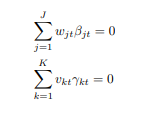

where $w_{jt}$ and $v_{kt}$ are the beginning-of-period market capitalisation weights of industry $j$ and country $k$ respectively. These are market capitalisation weights which sum to one: $\sum \limits_{j=1}^{J} w_{jt} = 1$ and $\sum \limits_{k=1}^{K} v_{jt} = 1$. These restrictions allow for the estimation of equation *(1)*, where this approach is equivalent to measuring country and industry effects relative to a market capitalisation-weighted benchmark. When imposing these restrictions on the model, estimated using *weighted least squares*, the $\alpha_{t}$ term in equation *(1)* is equal to the return on the value-weighted global portfolio. In other words, the restrictions imply that the value-weighted global portfolio has no country or industry effects, and country and industry effects are expressed relative to the global portfolio.

In [31]:
# Calculate Sector Weights

sector_weights = df.groupby(['Sector Name']).sum()['% Index Weight']
sector_weights

Sector Name
Communication Services     3.976059
Consumer Discretionary    11.514235
Consumer Staples          13.391256
Energy                     4.534904
Financials                15.756596
Health Care               14.366104
Industrials               14.492600
Information Technology     7.431812
Materials                  8.232914
Real Estate                1.430367
Utilities                  4.873153
Name: % Index Weight, dtype: float64

In [32]:
# Calculate Country Weights

country_weights = df.groupby(['Country']).sum()['% Index Weight']
country_weights

Country
Austria            0.276389
Belgium            1.627028
Denmark            3.919708
Finland            1.705028
France            17.935065
Germany           14.875075
Ireland            1.157810
Italy              3.808700
Netherlands        6.148901
Norway             0.926524
Portugal           0.266325
Spain              4.010908
Sweden             5.399363
Switzerland       15.200831
United Kingdom    22.742347
Name: % Index Weight, dtype: float64

In [33]:
country_weights.sum()

100.0

In [34]:
sector_weights.sum()

99.99999999999997

In [456]:
# help(sm.regression.linear_model.WLS) -> No constraints can be added!

In [41]:
y = df['1 Day %Change']
y.index = df['Symbol']
y.head()

Symbol
BNR-DE    0.764807
LXS-DE    1.678890
O2D-DE   -1.316500
EXO-IT    1.369560
MTX-DE    0.956609
Name: 1 Day %Change, dtype: float64

In [37]:
df.head()

,Name,Symbol,% Index Weight,Adj. Market Value,Adj. Shares,Price,1 Day %Change,Country,Sector Name
1,Brenntag AG,BNR-DE,0.123562,11956.310040,154.5,77.38710,0.764807,Germany,Industrials
2,LANXESS AG,LXS-DE,0.064291,6220.998194,83.0755,74.88370,1.678890,Germany,Materials
3,Telefonica Deutschland Holding AG,O2D-DE,0.029262,2831.494737,1041.09,2.71973,-1.316500,Germany,Communication Services
4,EXOR N.V.,EXO-IT,0.082157,7949.805786,108.45,73.30390,1.369560,Italy,Financials
5,MTU Aero Engines AG,MTX-DE,0.138366,13388.790547,53.0955,252.16400,0.956609,Germany,Industrials


In [482]:
# Model 1: Uncostrained (only Sector dummies without Intercept)

# intercept = pd.DataFrame(np.ones(len(y))); intercept.index = df['Symbol']
s_dummies = pd.get_dummies(df[['Sector Name']]); s_dummies.index = df['Symbol']
x_sector = cp.Variable(len(s_dummies.T))

# A = pd.merge(intercept, s_dummies, left_index = True, right_index = True)

cost = cp.sum_squares(s_dummies.values @ x_sector - y )
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

938.189795422831

In [483]:
print("Optimal value:", prob.value)
print("\nThe norm of the residuals is:", cp.norm(s_dummies.values @ x_sector - y, p = 2).value)
print("\nOptimal x_sector:\n")
print(x_sector.value)

Optimal value: 938.189795422831

The norm of the residuals is: 30.62988402561835

Optimal x_sector:

[-0.27565048  1.45911541 -0.47721353  0.76022215  1.39959663 -1.06478232
  0.78157318  1.21688235  1.53663403  0.97613523 -0.14691938]


In [484]:
sector_weights / 100 @ x_sector.value

0.5321965969340814

In [469]:
# Model 2: Constrained (Sector dummies plus Intercept) s.t. sum sector_weight * x = 0

# Set Constraints and add intercept

intercept = pd.DataFrame(np.ones(len(y))); intercept.index = df['Symbol']

A_sector = pd.merge(intercept, s_dummies, left_index = True, right_index = True)

x_sector_zero = cp.Variable(A_sector.shape[1])

sector_zero = cp.sum(np.ndarray(shape = (11, 1), buffer = sector_weights.values).T / 100 @ x_sector_zero[1:]) == 0
# sw_mod = pd.Series([0.0], index = ["Intercept"]).append(sector_weights)
# sector_zero = cp.sum(sw_mod / 100 @ x_sector_zero.value) == 0

cost = cp.sum_squares( A_sector.values @ x_sector_zero - y )
prob_sector_zero = cp.Problem(cp.Minimize(cost), [ sector_zero ])
prob_sector_zero.solve()

938.189795422831

In [470]:
print("Optimal value:", prob_sector_zero.value)
print("\nThe norm of the residuals is:", cp.norm(A.values @ x_sector_zero - y, p = 2).value)
print("\nOptimal x_sector:\n")
print(x_sector_zero[1:].value)

Optimal value: 938.189795422831

The norm of the residuals is: 30.62988402561835

Optimal x_sector:

[-0.80784708  0.92691881 -1.00941013  0.22802556  0.86740003 -1.59697892
  0.24937658  0.68468575  1.00443743  0.44393863 -0.67911597]


In [471]:
# Check Sector Constraint == 0

sector_weights / 100 @ x_sector_zero[1:].value

0.0

In [472]:
# Summary Table Unconstrained (no intercept) & Constrained

pd.DataFrame([x_sector.value, x_sector_zero.value[1:]],
             columns = sector_weights.index, index = ["Unconstrained", "Sector Constrained"])

Sector Name,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Unconstrained,-1.137386e-311,1.236121e-302,1.349837e-312,-0.000000,-0.0000,-0.000000,1.659093e-294,-0.000000,-0.000000,-0.000000,4.886560e-310
Sector Constrained,-8.078471e-01,9.269188e-01,-1.009410e+00,0.228026,0.8674,-1.596979,2.493766e-01,0.684686,1.004437,0.443939,-6.791160e-01


In [486]:
# Model 3: Constrained (Sector & Country dummies plus Intercept) s.t. sum sector_weight * x = 0 & sum country_weight * x = 0

# Set Constraints and add intercept

intercept.column = ['Intercept']
c_dummies = pd.get_dummies(df[['Country']]); c_dummies.index = df['Symbol']

A_sector_country = intercept.join(s_dummies).join(c_dummies)

x_sector_country_zero = cp.Variable(A_sector_country.shape[1])

sector_zero = cp.sum(np.ndarray(shape = (s_dummies.shape[1], 1), buffer = sector_weights.values).T / 100 @ x_sector_country_zero[1:s_dummies.shape[1]+1]) == 0
country_zero = cp.sum(np.ndarray(shape = (c_dummies.shape[1], 1), buffer = country_weights.values).T / 100 @ x_sector_country_zero[s_dummies.shape[1]+1:]) == 0

# sw_mod = pd.Series([0.0], index = ["Intercept"]).append(sector_weights)
# sector_zero = cp.sum(sw_mod / 100 @ x_sector_zero.value) == 0

cost = cp.sum_squares( A_sector_country.values @ x_sector_country_zero - y )
prob_sector_country_zero = cp.Problem(cp.Minimize(cost), [ sector_zero, country_zero ])
prob_sector_country_zero.solve()

880.5693012349575

In [487]:
print("Optimal value:", prob_sector_country_zero.value)
print("\nThe norm of the residuals is:", cp.norm(A_sector_country.values @ x_sector_country_zero - y, p = 2).value)
print("\nOptimal x_sector:\n")
print(x_sector_country_zero[1:].value)

Optimal value: 880.5693012349575

The norm of the residuals is: 29.674387967318843

Optimal x_sector:

[-0.86352943  0.88980896 -0.96020485  0.18831067  0.86183321 -1.60857775
  0.33926491  0.65889791  0.96449016  0.36601201 -0.72970013  1.68043949
  0.19505383 -0.26572757  0.2022113   0.01388904  0.37478704 -0.99528595
  0.14509366  0.04434555  0.168104   -1.38141865 -0.25992608 -0.62778602
 -0.30011984  0.15936641]


In [488]:
# Sector & Country coefficients (effects/returns)

pd.DataFrame(x_sector_country_zero[1:].value, index = A_sector_country.columns[1:])

,0
Sector Name_Communication Services,-0.863529
Sector Name_Consumer Discretionary,0.889809
Sector Name_Consumer Staples,-0.960205
Sector Name_Energy,0.188311
Sector Name_Financials,0.861833
Sector Name_Health Care,-1.608578
Sector Name_Industrials,0.339265
Sector Name_Information Technology,0.658898
Sector Name_Materials,0.964490
Sector Name_Real Estate,0.366012


In [493]:
# Check Country Constraint == 0

np.round(np.ndarray(shape = (c_dummies.shape[1], 1), buffer = country_weights.values).T / 100 @ x_sector_country_zero[s_dummies.shape[1]+1:].value,2)

array([-0.])

In [494]:
# Check Sector Constraint == 0

np.round(np.ndarray(shape = (s_dummies.shape[1], 1), buffer = sector_weights.values).T / 100 @ x_sector_country_zero[1:s_dummies.shape[1]+1].value,2)

array([0.])